In [2]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.models import Sequential , load_model
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
import matplotlib.pyplot as plt

(<Axes: >, <matplotlib.image.AxesImage at 0x2d0328c1a50>)

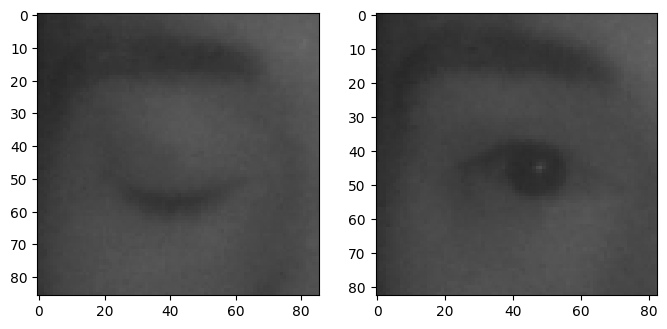

In [2]:
#arindamxd,dhirdevansh,kutaykutlu
img1 = cv2.imread('Data/train/closed/_1.png')
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)

img2 = cv2.imread('Data/train/open/_1.png')
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)

#** Test Img
plt.figure(figsize=(8,4))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)


In [11]:
num_classes = 2
trainpath = 'Data/train/'
testpath = 'Data/test/'
trainImg = [trainpath+f for f in listdir(trainpath)]
testImg = [testpath+f for f in listdir(testpath)]
img_size = 224

In [12]:
trainImg , testImg

(['Data/train/Closed', 'Data/train/Open'],
 ['Data/test/Closed', 'Data/test/Open'])

In [13]:
def img2data(path):
    rawImgs = []
    labels = []

    for imagePath in (path):
        print(imagePath)
        for item in tqdm(listdir(imagePath)):
            file = join(imagePath, item)
            if file[-1] =='g':
                img = cv2.imread(file , cv2.COLOR_BGR2RGB)
                img = cv2.resize(img ,(img_size,img_size))
                rawImgs.append(img)
            
                l = imagePath.split('/')[-1]
                if l == 'Closed':
                    labels.append([1,0])         
                elif l == 'Open':
                    labels.append([0,1])
            
    return rawImgs, labels

In [14]:
x_train, y_train = img2data(trainImg)
x_test, y_test = img2data(testImg)

Data/train/Closed


  0%|          | 0/26704 [00:00<?, ?it/s]

100%|██████████| 26704/26704 [00:08<00:00, 3113.48it/s]


Data/train/Open


100%|██████████| 26650/26650 [00:06<00:00, 3843.42it/s]


Data/test/Closed


100%|██████████| 349/349 [00:00<00:00, 1553.49it/s]


Data/test/Open


100%|██████████| 469/469 [00:00<00:00, 1822.63it/s]


In [15]:
x_train = np.array([cv2.resize(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), (img_size, img_size)) for image in x_train])
y_train = np.array(y_train)
x_test = np.array([cv2.resize(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), (img_size, img_size)) for image in x_test])
y_test = np.array(y_test)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [16]:
x_train.shape,y_train.shape,x_test.shape, y_test.shape

((53354, 224, 224, 3), (53354, 2), (818, 224, 224, 3), (818, 2))

In [31]:
base_model = VGG16(weights='imagenet',
                   include_top = False,
                   input_shape = (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,s

    Conv2D(64, (3,3), activation='relu',padding='same'),
    # MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),  # แปลงข้อมูลจาก 3D เป็นเวกเตอร์ 1 มิติ
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(num_classes, activation='softmax')  # สำหรับการจำแนกหลายคลาส
])

In [32]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,018,930 (57.29 MB)

 Trainable params: 304,242 (1.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics= ['accuracy'])
batch_size = 32
epochs = 10

In [34]:
history = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

Epoch 1/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 2899s 2s/step - accuracy: 0.8660 - loss: 0.2812 - val_accuracy: 0.9890 - val_loss: 0.0581
Epoch 2/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 2803s 2s/step - accuracy: 0.9739 - loss: 0.0818 - val_accuracy: 0.9878 - val_loss: 0.0352
Epoch 3/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 2836s 2s/step - accuracy: 0.9800 - loss: 0.0602 - val_accuracy: 0.9866 - val_loss: 0.0697
Epoch 4/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3438s 2s/step - accuracy: 0.9837 - loss: 0.0506 - val_accuracy: 0.9878 - val_loss: 0.1248
Epoch 5/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3485s 2s/step - accuracy: 0.9840 - loss: 0.0493 - val_accuracy: 0.9878 - val_loss: 0.1522
Epoch 6/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3459s 2s/step - accuracy: 0.9865 - loss: 0.0405 - val_accuracy: 0.9866 - val_loss: 0.1249
Epoch 7/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3429s 2s/step - accuracy: 0.9884 - loss: 0.0375 - val_accuracy: 0.9878 - val_loss: 0.1303
Epoch 8/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3731s 2s/step - accuracy: 0.9898 -

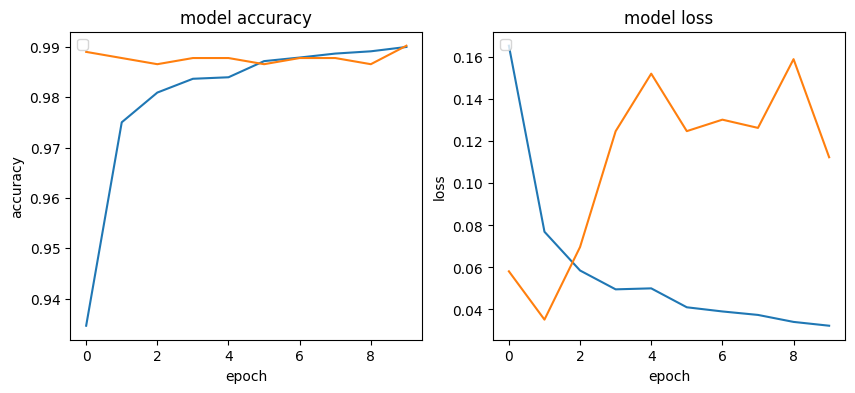

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['accuracy']);plt.plot(history.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['loss']);plt.plot(history.history['val_loss'])

In [38]:
testpath = 'Data/test/'
testImg = [testpath+f for f in listdir(testpath)]
for imagePath in (testImg):
    for i,item in enumerate(listdir(imagePath)):
        file = join(imagePath, item)
        print(file)

Data/test/Closed\_1.png
Data/test/Closed\_10.png
Data/test/Closed\_100.png
Data/test/Closed\_101.png
Data/test/Closed\_102.png
Data/test/Closed\_103.png
Data/test/Closed\_104.png
Data/test/Closed\_105.png
Data/test/Closed\_106.png
Data/test/Closed\_107.png
Data/test/Closed\_108.png
Data/test/Closed\_109.png
Data/test/Closed\_11.png
Data/test/Closed\_110.png
Data/test/Closed\_111.png
Data/test/Closed\_112.png
Data/test/Closed\_113.png
Data/test/Closed\_114.png
Data/test/Closed\_115.png
Data/test/Closed\_116.png
Data/test/Closed\_117.png
Data/test/Closed\_118.png
Data/test/Closed\_119.png
Data/test/Closed\_12.png
Data/test/Closed\_120.png
Data/test/Closed\_121.png
Data/test/Closed\_122.png
Data/test/Closed\_123.png
Data/test/Closed\_124.png
Data/test/Closed\_125.png
Data/test/Closed\_126.png
Data/test/Closed\_127.png
Data/test/Closed\_128.png
Data/test/Closed\_129.png
Data/test/Closed\_13.png
Data/test/Closed\_130.png
Data/test/Closed\_131.png
Data/test/Closed\_132.png
Data/test/Closed\_

In [3]:
testpath = 'Data/test/'
testImg = [testpath+f for f in listdir(testpath)]
rimg = []
valid_data = 0
last_index = 0
n = 0
for imagePath in (testImg):
      print(imagePath)
      if imagePath == testImg[len(listdir(testpath)) - 1]:
        last_index = len(listdir(testImg[0]))          
        for i,item in enumerate(listdir(imagePath)):
              print(last_index + i)
              file = join(imagePath, item)
              if file[-1] =='g':
                print(file)
                imgori = cv2.imread(file)
                imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
                img = cv2.resize(imgori ,(img_size,img_size))
                rimg = np.array(img)
                rimg = rimg.astype('float32')
                rimg /= 255
                rimg = np.reshape(rimg ,(1,224,224,3))
                predict = model.predict(rimg)
                label = ['Closed','Opened']
                result = label[np.argmax(predict)]
                plt.title(imagePath)
                cv2.putText(imgori, str(result), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )
                print(f"Predict : {predict}\nDefault : {y_train[(last_index + i)]}")
                plt.imshow(imgori)
                plt.show()

Data/test/Closed
Data/test/Open
349
Data/test/Open\_1.png


NameError: name 'img_size' is not defined

In [35]:
model.save('CNNWithVGG.keras')